# K-Means Clustering

# 1) Use the "Breast Cancer Wisconsin (Diagnostic) Data Set" from Kaggle to try and cluster types of cancer cells. 

Here's the original dataset for your reference:

<https://www.kaggle.com/uciml/breast-cancer-wisconsin-data>

## This is a supervised learning dataset

(Because it has **labels** - The "diagnosis" column.)

In [222]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA # You don't necessarily have to use this
from sklearn.cluster import KMeans # You don't necessarily have to use this
from sklearn.preprocessing import StandardScaler # You don't necessarily have to use this

df = pd.read_csv("https://raw.githubusercontent.com/ryanleeallred/datasets/master/Cancer_Cells.csv")
print(df.shape)
df.head()

(569, 33)


,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,radius_se,texture_se,perimeter_se,area_se,smoothness_se,compactness_se,concavity_se,concave points_se,symmetry_se,fractal_dimension_se,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,1.0950,0.9053,8.589,153.40,0.006399,0.04904,0.05373,0.01587,0.03003,0.006193,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,NaN
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,0.5435,0.7339,3.398,74.08,0.005225,0.01308,0.01860,0.01340,0.01389,0.003532,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,NaN
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,0.7456,0.7869,4.585,94.03,0.006150,0.04006,0.03832,0.02058,0.02250,0.004571,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,NaN
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,0.4956,1.1560,3.445,27.23,0.009110,0.07458,0.05661,0.01867,0.05963,0.009208,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,NaN
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,0.7572,0.7813,5.438,94.44,0.011490,0.02461,0.05688,0.01885,0.01756,0.005115,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,NaN


## Now it's an unsupervised learning dataset

(Because we've removed the diagnosis label) - Use this version.

In [223]:
origin = df.drop('diagnosis', axis=1)
origin = df.drop('Unnamed: 32', axis=1)
origin.head()

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,radius_se,texture_se,perimeter_se,area_se,smoothness_se,compactness_se,concavity_se,concave points_se,symmetry_se,fractal_dimension_se,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,1.0950,0.9053,8.589,153.40,0.006399,0.04904,0.05373,0.01587,0.03003,0.006193,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,0.5435,0.7339,3.398,74.08,0.005225,0.01308,0.01860,0.01340,0.01389,0.003532,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,0.7456,0.7869,4.585,94.03,0.006150,0.04006,0.03832,0.02058,0.02250,0.004571,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,0.4956,1.1560,3.445,27.23,0.009110,0.07458,0.05661,0.01867,0.05963,0.009208,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,0.7572,0.7813,5.438,94.44,0.011490,0.02461,0.05688,0.01885,0.01756,0.005115,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


## Let's do it!

- You might want to do some data exploration to see if you can find specific columns that will help you find distinct clusters of cells
- You might want to use the elbow method to decide on the number of clusters to use.


In [0]:
#importing standardization tools
from sklearn.preprocessing import StandardScaler

In [0]:
#instantiating standard scalar 
myscaler = StandardScaler()

In [151]:
#standardizing the data
scaled_df = myscaler.fit_transform(origin)
scaled_df = pd.DataFrame(scaled_df)
scaled_df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30
0,-0.236405,1.097064,-2.073335,1.269934,0.984375,1.568466,3.283515,2.652874,2.532475,2.217515,2.255747,2.489734,-0.565265,2.833031,2.487578,-0.214002,1.316862,0.724026,0.660820,1.148757,0.907083,1.886690,-1.359293,2.303601,2.001237,1.307686,2.616665,2.109526,2.296076,2.750622,1.937015
1,-0.236403,1.829821,-0.353632,1.685955,1.908708,-0.826962,-0.487072,-0.023846,0.548144,0.001392,-0.868652,0.499255,-0.876244,0.263327,0.742402,-0.605351,-0.692926,-0.440780,0.260162,-0.805450,-0.099444,1.805927,-0.369203,1.535126,1.890489,-0.375612,-0.430444,-0.146749,1.087084,-0.243890,0.281190
2,0.431741,1.579888,0.456187,1.566503,1.558884,0.942210,1.052926,1.363478,2.037231,0.939685,-0.398008,1.228676,-0.780083,0.850928,1.181336,-0.297005,0.814974,0.213076,1.424827,0.237036,0.293559,1.511870,-0.023974,1.347475,1.456285,0.527407,1.082932,0.854974,1.955000,1.152255,0.201391
3,0.432121,-0.768909,0.253732,-0.592687,-0.764464,3.283553,3.402909,1.915897,1.451707,2.867383,4.910919,0.326373,-0.110409,0.286593,-0.288378,0.689702,2.744280,0.819518,1.115007,4.732680,2.047511,-0.281464,0.133984,-0.249939,-0.550021,3.394275,3.893397,1.989588,2.175786,6.046041,4.935010
4,0.432201,1.750297,-1.151816,1.776573,1.826229,0.280372,0.539340,1.371011,1.428493,-0.009560,-0.562450,1.270543,-0.790244,1.273189,1.190357,1.483067,-0.048520,0.828471,1.144205,-0.361092,0.499328,1.298575,-1.466770,1.338539,1.220724,0.220556,-0.313395,0.613179,0.729259,-0.868353,-0.397100


In [152]:
# checking for low covariance to try to find areas where clusters would exist 
scaled_df.corr()[scaled_df.corr() < 0.01]

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30
0,NaN,NaN,NaN,NaN,NaN,-0.012968,0.000096,NaN,NaN,-0.022114,-0.052511,NaN,-0.007526,NaN,NaN,NaN,NaN,NaN,NaN,-0.017306,NaN,NaN,NaN,NaN,NaN,NaN,-0.002968,NaN,NaN,-0.044224,-0.029866
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.311631,NaN,-0.097317,NaN,NaN,-0.222600,NaN,NaN,NaN,-0.104321,-0.042641,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.007066
2,NaN,NaN,NaN,NaN,NaN,-0.023389,NaN,NaN,NaN,NaN,-0.076437,NaN,NaN,NaN,NaN,0.006614,NaN,NaN,NaN,0.009127,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.261477,NaN,-0.086761,NaN,NaN,-0.202694,NaN,NaN,NaN,-0.081629,-0.005523,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.283110,NaN,-0.066280,NaN,NaN,-0.166777,NaN,NaN,NaN,-0.072497,-0.019887,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.003738
5,-0.012968,NaN,-0.023389,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,0.000096,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,-0.022114,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [0]:
#picking two features with low corrolation to eachother 
features = ['fractal_dimension_worst', 'area_mean']
df_features = df[features]
df_features = myscaler.fit_transform(df_features)
df_features = pd.DataFrame(df_features)

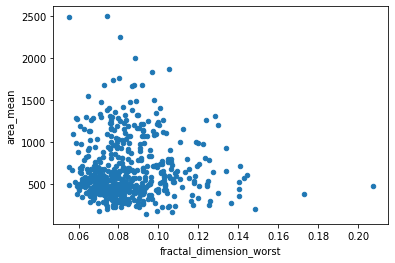

In [154]:
#plotting to get a handle on the data I'm working with 
df[features].plot(kind='scatter', x=features[0], y=features[1])

In [0]:
#creating an elbow plot 
sum_of_squared_distances = []
K = range(1,15)
for k in K:
  km=KMeans(n_clusters=k)
  km = km.fit(df[features])
  sum_of_squared_distances.append(km.inertia_)

''

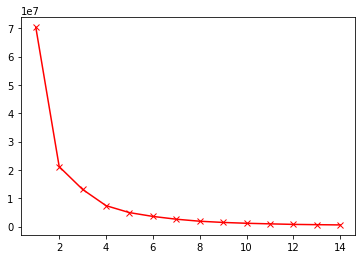

In [156]:
plt.plot(K, sum_of_squared_distances, 'rx-')
;

In [0]:
#3 k looks to be optimal for the dataset 
#importing kmean
from sklearn.cluster import KMeans

In [0]:
#instatiating the kmeans model
model = KMeans(n_clusters=3)

In [159]:
model.fit(df[features].values)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=3, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [0]:
df_features['clusters'] = model.labels_
labels = model.labels_

In [161]:
df_features.head()

,0,1,clusters
0,1.937015,0.984375,0
1,0.281190,1.908708,2
2,0.201391,1.558884,2
3,4.935010,-0.764464,1
4,-0.397100,1.826229,2


In [0]:
#pulling the centroids
centroids = model.cluster_centers_

In [163]:
#turning centroids to a dataframe 
cent = pd.DataFrame(centroids)
cent

,0,1
0,0.085922,775.991781
1,0.082924,435.985588
2,0.084653,1338.578313


In [0]:
#setting up colors for plotting 
base_colors = ['r', 'b','g']
colors = [base_colors[centroid] for centroid in model.labels_]

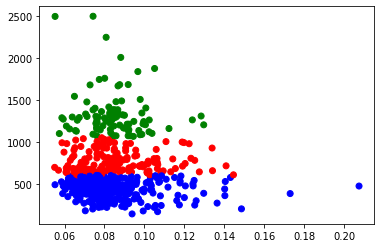

In [165]:
#plotting a scatter plot with the calculated centroids
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
ax.scatter(df[features[0]], df[features[1]], c=colors)
ax.scatter(cent[0], cent[1], c=base_colors, s=200)

In [166]:
#checking the silouete score on this 
from sklearn import metrics
metrics.silhouette_score(df[features], labels, metric='euclidean')

0.5666408593193107

## Check you work: 

This is something that in a truly unsupervised learning situation **WOULD NOT BE POSSIBLE**. But for educational purposes go back and grab the true diagnosis column (label) from the original dataset. Take your cluster labels and compare them to the original diagnosis column. You can make scatterplots for each to see how they compare or you can calculate a percent accuracy score like: 
\begin{align}
\frac{\text{Num Correct Labels}}{\text{Num Total Observations}}
\end{align}

In [227]:
# Your Code Here
#reading back in the true metric 
df_features['diagnosis'] = df['diagnosis']
df_features.sample(5)

,0,1,clusters,diagnosis
61,-0.378258,-1.231750,1,B
132,-0.429795,0.440582,0,M
395,-0.989495,-0.130229,0,B
353,0.578219,0.175512,0,M
511,-1.248287,0.073409,0,B


# 2) Perform PCA on your dataset first and *then* use k-means clustering. 

- You need to standardize your data before PCA.
- First try clustering just on PC1 and PC2 so that you can make a scatterplot of your clustering.
- Then use use a scree plot to decide how many principal components to include in your clustering, and use however many principal components you need in order to retain 90% of the variation of the original dataset



In [0]:
##### Your Code Here #####

In [0]:
#imports for PCA
from sklearn.decomposition import PCA

In [0]:
#instantiating PCA
mypca = PCA(n_components=2)

In [171]:
#running PCA on the 
pca_cancer = mypca.fit_transform(scaled_df)
pca_cancer

array([[ 9.18319983,  1.97127137],
       [ 2.38329766, -3.75345877],
       [ 5.74247239, -1.08035048],
       ...,
       [ 1.2518901 , -1.89397674],
       [10.36503528,  1.69639755],
       [-5.47826365, -0.67278804]])

In [172]:
#how much variance was described 
sum(mypca.explained_variance_ratio_)

0.6124149284660225

In [173]:
#turning the pca into a dataframe
df_pca = pd.DataFrame(pca_cancer, columns=['comp_1', 'comp_2'])
df_pca.head()

,comp_1,comp_2
0,9.183200,1.971271
1,2.383298,-3.753459
2,5.742472,-1.080350
3,7.124384,10.272225
4,3.945694,-1.959689


In [0]:
#initializing clustering!!!
model = KMeans(n_clusters=3)

In [175]:
model.fit(df_pca.values)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=3, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [0]:
df_pca['cluster'] = model.labels_

In [178]:
df_pca.sample(5)

,comp_1,comp_2,cluster
38,-0.999552,-3.353120,0
306,-3.857853,-1.517757,0
217,-2.760349,1.086262,0
36,1.289467,0.925384,2
118,4.948479,2.400377,2


In [180]:
#getting centroids
centroids = model.cluster_centers_
cent = pd.DataFrame(centroids)
cent.head()

,0,1
0,-2.373475,-0.258771
1,5.061346,-1.737493
2,2.168446,3.169598


In [0]:
base_colors = ['r', 'g', 'b']
colors = [base_colors[centroid] for centroid in model.labels_]

array([0.42864701, 0.18376792])

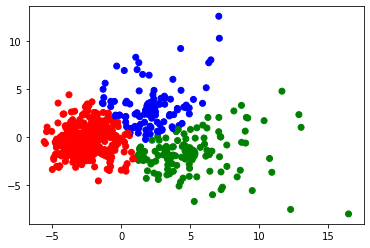

In [183]:
#plotting a scatter plot with the calculated centroids
fig, ax = plt.subplots()
ax.scatter(df_pca['comp_1'], df_pca['comp_2'], c=colors)
ax.scatter(cent[0], cent[1], c=base_colors, s=200)

In [221]:
metrics.silhouette_score(scaled_df, df_pca['cluster'], metric='euclidean')

0.3042897515592752

Scree Plot 

In [0]:
mypca = PCA(n_components=20)

In [197]:
mypca.fit(scaled_df)

PCA(copy=True, iterated_power='auto', n_components=20, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

In [198]:
#Creating a scree plot to determine best number of components 
#defining num of components 
num_components = len(mypca.explained_variance_ratio_)
num_components

20

In [199]:
#creating np array as long as components 
import numpy as np
ind = np.arange(num_components)
ind

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19])

In [200]:
#creating array for explained varaince 
vals = mypca.explained_variance_ratio_
vals

array([0.42864701, 0.18376792, 0.09146436, 0.06391475, 0.05318759,
       0.03982815, 0.0315572 , 0.02166945, 0.01486427, 0.01300429,
       0.01126306, 0.00948034, 0.00842409, 0.00778485, 0.00506367,
       0.0030364 , 0.00257451, 0.00190472, 0.00169649, 0.00158458])

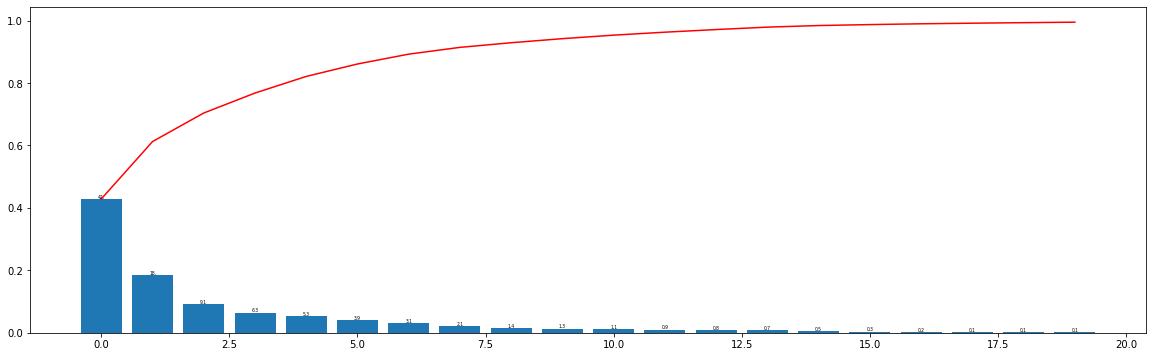

In [201]:
# Define scree plot function
plt.figure(figsize=(20, 6))
ax = plt.subplot(111)
cumvals = np.cumsum(vals)
ax.bar(ind, vals)
ax.plot(ind, cumvals, c='r')
for i in range(num_components):
        ax.annotate(r"%s" % ((str(vals[i]*100)[:3])), (ind[i], vals[i]), va="bottom", ha="center", fontsize=4.5)

In [0]:
mypca = PCA(n_components=8)

In [209]:
mypca.fit(scaled_df)

PCA(copy=True, iterated_power='auto', n_components=8, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

In [210]:
sum(mypca.explained_variance_ratio_)

0.9140364266907842

In [0]:
pca_features = mypca.fit_transform(scaled_df)

In [213]:
df_pca8 = pd.DataFrame(pca_features, columns=['comp1', 'comp2', 'comp3', 'comp4', 'comp5', 'comp6', 'comp7', 'comp8'])
df_pca8.sample(5)

,comp1,comp2,comp3,comp4,comp5,comp6,comp7,comp8
526,-0.849339,0.084469,-2.747218,0.152480,-0.642016,0.621164,0.650617,-0.127446
300,6.584070,-1.468814,0.313355,1.199296,-0.118406,0.720616,-0.593427,1.226872
288,0.399168,3.718411,4.561350,0.246444,0.818867,-1.870632,0.215235,-2.496691
129,4.637113,-1.464030,-1.211657,-1.210077,0.184109,-0.780877,-0.258172,-0.683331
226,-3.883642,0.519303,-0.819257,1.015676,-0.819342,0.869835,0.378550,0.469874


In [0]:
#running Kmean analysis
model = KMeans(n_clusters=3)

In [215]:
model.fit(df_pca8)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=3, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [216]:
df_pca8['cluster'] = model.labels_
df_pca8.sample(5)

,comp1,comp2,comp3,comp4,comp5,comp6,comp7,comp8,cluster
309,-4.030628,-2.538784,0.320384,1.522623,0.669240,0.025300,-0.211346,0.876061,1
235,-2.322064,-1.368264,0.283548,-1.226277,0.045558,1.281435,-0.091363,-0.182594,1
6,2.233527,-2.674076,-1.675735,0.150643,0.041702,0.055812,-0.262267,-0.277769,0
226,-3.883642,0.519303,-0.819257,1.015676,-0.819342,0.869835,0.378550,0.469874,1
472,-1.404242,-1.761004,-1.509204,1.309263,1.805725,-0.584972,0.160238,0.281513,1


In [217]:
metrics.silhouette_score(scaled_df, df_pca8['cluster'], metric='euclidean')

0.3053710609929348

## Check your work: 

- Compare your PC1, PC2 clustering scatterplot to the clustering scatterplots you made on the raw data
- Calculate accuracy scores for both the PC1,PC2 Principal component clustering and the 90% of explained variance clustering.

How do your accuracy scores -when preprocessing the data with PCA- compare to the accuracy when simply clustering on the raw data?

# Stretch Goals:

- Study for the Sprint Challenge
- Work on your Data Storytelling Project